# Multinomial vs Bernoulli Naive Bayes

In [1]:
import numpy as np
import re
import itertools 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.stem import (SnowballStemmer, PorterStemmer) 
from nltk.tokenize import wordpunct_tokenize

import matplotlib.pyplot as plt
%matplotlib inline

### Tokenization (stemming) 

In [2]:
stemmer = PorterStemmer()#("english", ignore_stopwords=True)

def load_data(input_name):
  data = open(input_name).read()
  lines = data.splitlines()
  return lines 

def process(line):
  return ([stemmer.stem(word.lower())
           for word in wordpunct_tokenize(line) 
           if re.match(r'[a-z]+(!)*', word.lower())])

def tokenize_stem(line):
  return " ".join(process(line))

#classes = [line[0] for line in data]
#smss = [line[1:] for line in data]

## Data 
## [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

In [3]:
smss = load_data('data/SMSSpamCollection')
tokenized_smss = [tokenize_stem(line.split('\t', 1)[1]) for line in smss]

In [4]:
for i in range(5):
  print('sms')
  print(smss[i])
  print('sms after tokenization')
  print(tokenized_smss[i])

sms
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
sms after tokenization
go until jurong point crazi avail onli in bugi n great world la e buffet cine there got amor wat
sms
ham	Ok lar... Joking wif u oni...
sms after tokenization
ok lar joke wif u oni
sms
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
sms after tokenization
free entri in a wkli comp to win fa cup final tkt may text fa to to receiv entri question std txt rate t c s appli s
sms
ham	U dun say so early hor... U c already then say...
sms after tokenization
u dun say so earli hor u c alreadi then say
sms
ham	Nah I don't think he goes to usf, he lives around here though
sms after tokenization
nah i don t think he goe to usf he live around here though


In [5]:
vectorizer = CountVectorizer() 

data = vectorizer.fit_transform(tokenized_smss)
target = np.array([line[:3] for line in smss]) != 'ham'

In [6]:
print("Percentage of spam examples:", str(100 *round(target.mean(),4)) + "%")
print("Baseline 'not spam' has", str(100 * (1 - round(target.mean(),4))) + "% accuracy")

Percentage of spam examples: 13.4%
Baseline 'not spam' has 86.6% accuracy


### Scikit-learn

In sklearn we have 2 kinds of Naive Bayes classifiers for categorical data

* [Multinomial](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)

* [Bernoulli](http://scikit-learn.org/stable/modules/naive_bayes.html#bernoulli-naive-bayes)

In [7]:
mnb = naive_bayes.MultinomialNB()
bnb = naive_bayes.BernoulliNB()

param_grid = {"alpha": np.linspace(0.01, 1, 50)}

mnb_cv = GridSearchCV(mnb, param_grid, cv = 10)
bnb_cv = GridSearchCV(bnb, param_grid, cv = 10)

In [8]:
mnb_cv.fit(data, target)
print("Best Multinomial NB accuracy:", mnb_cv.best_score_)
print("alpha for best accuracy", mnb_cv.best_params_)

Best Multinomial NB accuracy: 0.981700753498
alpha for best accuracy {'alpha': 0.01}


In [9]:
bnb_cv.fit(data, target)
print("Best Bernoulli NB accuracy:", bnb_cv.best_score_)
print("alpha for best accuracy", bnb_cv.best_params_)

Best Bernoulli NB accuracy: 0.986903480445
alpha for best accuracy {'alpha': 0.01}


In [10]:
[data_train, data_test, target_train, target_test] = train_test_split(data, target)

In [11]:
def model_confusion_matrix(model, X, y, X_test, y_test):
  model.fit(X, y)
  y_predicted = model.predict(X_test)
  return confusion_matrix(y_predicted, y_test)

# Confusion matrix

Since the data is severely unbalanced it's best use different metrics for classification, namely

$TP/(TP+FN)$

i 

$TN/(TN+FN)$

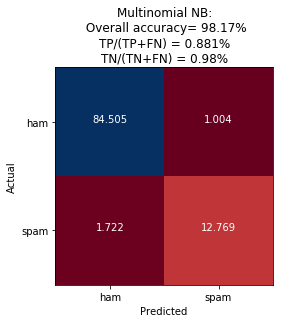

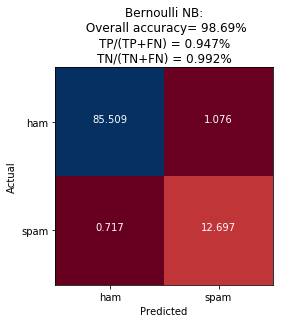

In [12]:
for (clf, name) in [(mnb_cv, "Multinomial NB"), (bnb_cv, "Bernoulli NB")]:
  best = clf.best_estimator_
  cm = model_confusion_matrix(best, data_train, target_train, data_test, target_test)
  plt.imshow(cm, interpolation='nearest', cmap='RdBu')
  
  interp = '{}:\n Overall accuracy= {}%\nTP/(TP+FN) = {}%\nTN/(TN+FN) = {}%'
  plt.title((
    interp.format(
        name,
        round(100 * clf.best_score_, 3),
        round(cm[1,1] / (cm[1, 1] + cm[1, 0]), 3),
        round(cm[0,0] / (cm[0, 0] + cm[1, 0]), 3)
      ))
  )
  
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.xticks([0,1], ['ham', 'spam'] )
  plt.yticks([0,1], ['ham', 'spam'] )
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i,
                   100 * round(cm[i, j] / cm.sum(), 5),
                   horizontalalignment="center",
                   color="white")
  
  plt.show()